### notebook applies 3 methods for stippling significant changes in spatial data 

* Simple t-test at each grid cell without any mutiple test corrections 
* Bonferroni correction (p_bonf = p/N)
* False-discovery ratio method, following Wilks (2016)

The aim is to show how and why the output varies between these methods. We use UKESM1 model outputs. 

See slides here https://docs.google.com/presentation/d/1geONKn4nO5IAES4SzIG0uC7enrXhLYuTCq3Rae7av08/edit#slide=id.p

FDR threshold function is adapted from Fabien Maussion's implemenetation here https://fabienmaussion.info/2017/01/30/trendy-triangles-fdr/


Alistair Duffey 
alistaur.duffey.21@ucl.ac.uk

In [39]:
import os
import glob
import iris
import pandas as pd
import numpy as np
import logging
import xarray as xr
from xmip.preprocessing import rename_cmip6
import matplotlib
import matplotlib.pyplot as plt
import dask
#from nc_processing import calc_spatial_mean
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
matplotlib.rcParams.update({'font.size': 15})

from scipy.fftpack import fft2, ifft2, fftfreq

N = (144*192)

In [2]:
# Define a function to apply the t-test to each pixel
def ttest_ind_from_stats_pixel(mean1, std1, nobs1, mean2, std2, nobs2):
    t_stat, p_value = stats.ttest_ind_from_stats(mean1, std1, nobs1, 
                                                 mean2, std2, nobs2, 
                                                 equal_var=False, alternative='two-sided')
    return t_stat, p_value

 
def ttest_xr(mean1, std1, nobs1, mean2, std2, nobs2):
    # Use xr.apply_ufunc to apply this function element-wise across the arrays
    t_stat, p_value = xr.apply_ufunc(
        ttest_ind_from_stats_pixel, 
        mean1, std1, nobs1, 
        mean2, std2, nobs2,
        input_core_dims=[[], [], [], [], [], []],  # No core dimensions; apply to each element
        output_core_dims=[[], []],                 # Output is a scalar for each pixel
        vectorize=True                             # Apply element-wise
    )
    return t_stat, p_value



In [3]:
import numpy as np
from scipy.stats import t

def welchs_ttest_array(mean1, std1, n1, mean2, std2, n2):

    mean1, std1, n1 = np.array(mean1), np.array(std1), np.array(n1)
    mean2, std2, n2 = np.array(mean2), np.array(std2), np.array(n2)
    
    numerator = mean1 - mean2
    denominator = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    t_stat = numerator / denominator

    v1 = (std1**2 / n1)
    v2 = (std2**2 / n2)
    df = ((v1 + v2)**2) / ((v1**2 / (n1 - 1)) + (v2**2 / (n2 - 1)))

    return t_stat, df

def calculate_pvalue_array(t_stat, df):
    # Calculate two-sided p-values
    p_values = 2 * t.sf(np.abs(t_stat), df)
    return p_values

In [4]:
def fdr_threshold(pvalues, alpha=0.05):
    """Calculate the FDR threshold following Wilks (2016)"""
    pvals_sorted = np.sort(np.asarray(pvalues).flatten())
    N = len(pvals_sorted)
    return np.max(np.where(pvals_sorted <= (np.arange(1, N+1) / N * alpha), pvals_sorted, 0))

In [9]:
### read in some SSP245 data:

### options

# Model
model = 'UKESM1-0-LL'

# time-periods over which to take means
assessment_periods = {'SAI':slice('2050', '2069'),
                      'Background_warming':slice('2050', '2069'),
                      'Baseline':slice('2014', '2033'),
                      'Pre-industrial':slice('1850', '1900')}

# ARISE ensemble_members. We also only use these same members for the baseline
ens_mems = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']

var = 'tas'

### get historical-SSP2-4.5 and combine along the time dimension

def get_historical_ssp245_ds(variable, table='Amon'):
    """ gets historical and SSP2-4.5 and combine along the time dimension
        returns dataset with 5 members, each running over the historical 
        1850-2014 and ssp245 2015-2100 """
    
    ds_list = []
    for es in ens_mems:
        path = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/{e}/{t}/{v}/*/latest/'.format(e=es, t=table,v=variable)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        
        path_hist = glob.glob('/badc/cmip6/data/CMIP6/*/*/UKESM1-0-LL/historical/{e}/{t}/{v}/*/latest/'.format(
        t=table, v=variable, e=es))[0]
        ds_hist = rename_cmip6(xr.open_mfdataset(path_hist+'*.nc'))    
        ds = xr.concat([ds_hist, ds], dim='time')
        if 'height' in ds.variables:
            ds = ds.drop_vars('height')
        if 'type' in ds.variables:
            ds = ds.drop_vars('type')
        ds_list.append(ds)
    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS

DS = get_historical_ssp245_ds(var)
DS = DS.groupby(DS.time.dt.year).mean()

DS_early = DS.sel(year=slice(1850, 1900))
DS_late = DS.sel(year=slice(2050, 2100))

In [10]:
"""
def plot_mains(ds_1, ds_2, 
               suptitle, 
               label,
               var,
               col_bar_label,
               p_thresh = 0.05,
               alpha = 0.05,
               clevs=np.arange(-2,2.1,0.25),
               cols = 'RdBu_r'):
    
    sig_masks = []
    t_stat, df = welchs_ttest_array(mean1=ds_1.mean('year')[var].values, 
                                    std1=ds_1.std('year')[var].values,
                                    n1=np.full_like(ds_1.std('year')[var].values, 100),
                                    mean2=ds_2.mean('year')[var].values, 
                                    std2=ds_2.std('year')[var].values,
                                    n2=np.full_like(ds_2.std('year')[var].values, 100))
    d = (ds_2.mean('year') - ds_1.mean('year'))[var]
    
    p_values = calculate_pvalue_array(t_stat, df)
    p_values_xr = ds_1.mean('year').copy()
    p_values_xr[var].values = p_values
    
    p_thresh_fdr = fdr_threshold(p_values, alpha)
    print(p_thresh_fdr)
    
    ### plots
    fig, axs = plt.subplots(nrows=2,ncols=1,
                            subplot_kw={'projection': ccrs.Robinson()},
                            figsize=(7,7))
    
    data,lons=add_cyclic_point(d,coord=d['x'])
    
    
    ax = axs[0]
    cs=ax.contourf(lons,d['y'],data,clevs,
                   transform = ccrs.PlateCarree(),
                   cmap=cols,
                   extend='both')
    sig_mask = xr.where(p_values_xr[var]<p_thresh, 1, 0)
    sig_masks.append(sig_mask)
    sig_mask_,lons=add_cyclic_point(sig_mask, coord=sig_mask['x'])
    cs_hatch = ax.contourf(lons,sig_mask['y'],sig_mask_,
                   transform = ccrs.PlateCarree(),
                   levels=[0, 0.2, 1.2], colors='none',
                   hatches=[None,'..', '..'],
                   extend='neither', zorder=1000)
    # New bit here that handles changing the color of hatches
    colors = ['lime', 'magenta', 'magenta']
    # For each level, we set the color of its hatch 
    for l, collection in enumerate(cs_hatch.collections):
        collection.set_edgecolor(colors[l % len(colors)])
    # Doing this also colors in the box around each level
    # We can remove the colored line around the levels by setting the linewidth to 0
    for collection in cs_hatch.collections:
        collection.set_linewidth(0.)
    ax.coastlines()
    ax.set_title('p < 0.05')
    
    
    ax = axs[1]
    cs=ax.contourf(lons,d['y'],data,clevs,
                   transform = ccrs.PlateCarree(),
                   cmap=cols,
                   extend='both')
    sig_mask = xr.where(p_values_xr[var]<p_thresh_fdr, 1, 0)
    sig_masks.append(sig_mask)
    sig_mask_,lons=add_cyclic_point(sig_mask, coord=sig_mask['x'])
    cs_hatch = ax.contourf(lons,sig_mask['y'],sig_mask_,
                   transform = ccrs.PlateCarree(),
                   levels=[0, 0.2, 1.2], colors='none',
                   hatches=[None,'..', '..'],
                   extend='neither', zorder=1000)
    # New bit here that handles changing the color of hatches
    colors = ['lime', 'magenta', 'magenta']
    # For each level, we set the color of its hatch 
    for l, collection in enumerate(cs_hatch.collections):
        collection.set_edgecolor(colors[l % len(colors)])
    # Doing this also colors in the box around each level
    # We can remove the colored line around the levels by setting the linewidth to 0
    for collection in cs_hatch.collections:
        collection.set_linewidth(0.)
        
    ax.coastlines()
    ax.set_title('FDR = {a}, p < {b}'.format(a=alpha, b=np.round(p_thresh_fdr, 3)))
    
    ### Add a colorbar
    # Adjust the layout to make room for the colorbar on the right
    plt.subplots_adjust(right=0.8, hspace=0.4)
    # Create a colorbar to the right of the subplots
    cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # (left, bottom, width, height)
    cbar = plt.colorbar(cs, cax=cax, orientation='vertical', label=col_bar_label)
    
    plt.suptitle(suptitle)    
    plt.savefig('Figures/{}_maps.jpg'.format(label), dpi=250)


    ########################################################

    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
    ax=axs[0]
    pvals_sorted = np.sort(np.asarray(p_values).flatten())
    ax.plot(pvals_sorted)
    ax.plot((np.arange(1, len(pvals_sorted)+1) / len(pvals_sorted) * alpha), label='{}*(i/N)'.format(alpha))
    ax.axhline(p_thresh, ls='--', c='gray', label=p_thresh)
    ax.axhline(p_thresh_fdr, ls='--', c='red', label=np.round(p_thresh_fdr, 7))
    ax.set_ylim(0, 0.1)
    ax.set_ylabel('p_value')
    ax.set_xlabel('rank')
    ax.legend()

    ax=axs[1]
    ax.hist(pvals_sorted, bins=30)
    ax.set_xlabel('p_values')
    ax.set_ylabel('count')
    plt.tight_layout()
    plt.savefig('Figures/{}_lines.jpg'.format(label), dpi=350)

    
    return sig_masks
    """

In [33]:
def plot_mains(ds_1, ds_2, 
               suptitle, 
               label,
               var,
               col_bar_label,
               p_thresh = 0.05,
               alpha = 0.05,
               clevs=np.arange(-2,2.1,0.25),
               cols = 'RdBu_r'):
    
    sig_masks = []
    t_stat, df = welchs_ttest_array(mean1=ds_1.mean('year')[var].values, 
                                    std1=ds_1.std('year')[var].values,
                                    n1=np.full_like(ds_1.std('year')[var].values, 100),
                                    mean2=ds_2.mean('year')[var].values, 
                                    std2=ds_2.std('year')[var].values,
                                    n2=np.full_like(ds_2.std('year')[var].values, 100))
    d = (ds_2.mean('year') - ds_1.mean('year'))[var]
    
    p_values = calculate_pvalue_array(t_stat, df)
    p_values_xr = ds_1.mean('year').copy()
    p_values_xr[var].values = p_values
    
    p_thresh_fdr = fdr_threshold(p_values, alpha)
    print(p_thresh_fdr)
    
    ### plots
    fig, axs = plt.subplots(nrows=1,ncols=3,
                            subplot_kw={'projection': ccrs.Robinson()},
                            figsize=(10,4))
    
    data,lons=add_cyclic_point(d,coord=d['x'])
    
    
    ax = axs[0]
    cs=ax.contourf(lons,d['y'],data,clevs,
                   transform = ccrs.PlateCarree(),
                   cmap=cols,
                   extend='both')
    sig_mask = xr.where(p_values_xr[var]<p_thresh, 1, 0)
    sig_masks.append(sig_mask)
    sig_mask_,lons=add_cyclic_point(sig_mask, coord=sig_mask['x'])
    cs_hatch = ax.contourf(lons,sig_mask['y'],sig_mask_,
                   transform = ccrs.PlateCarree(),
                   levels=[0, 0.2, 1.2], colors='none',
                   hatches=[None,'..', '..'],
                   extend='neither', zorder=1000)
    # New bit here that handles changing the color of hatches
    colors = ['lime', 'magenta', 'magenta']
    # For each level, we set the color of its hatch 
    for l, collection in enumerate(cs_hatch.collections):
        collection.set_edgecolor(colors[l % len(colors)])
    # Doing this also colors in the box around each level
    # We can remove the colored line around the levels by setting the linewidth to 0
    for collection in cs_hatch.collections:
        collection.set_linewidth(0.)
    ax.coastlines()
    ax.set_title('p < 0.05')
    

    ### do a bonferroni correction p thresh
    ax = axs[1]
    cs=ax.contourf(lons,d['y'],data,clevs,
                   transform = ccrs.PlateCarree(),
                   cmap=cols,
                   extend='both')
    sig_mask = xr.where(p_values_xr[var]<p_thresh/(144*192), 1, 0)
    sig_masks.append(sig_mask)
    sig_mask_,lons=add_cyclic_point(sig_mask, coord=sig_mask['x'])
    cs_hatch = ax.contourf(lons,sig_mask['y'],sig_mask_,
                   transform = ccrs.PlateCarree(),
                   levels=[0, 0.2, 1.2], colors='none',
                   hatches=[None,'..', '..'],
                   extend='neither', zorder=1000)
    # New bit here that handles changing the color of hatches
    colors = ['lime', 'magenta', 'magenta']
    # For each level, we set the color of its hatch 
    for l, collection in enumerate(cs_hatch.collections):
        collection.set_edgecolor(colors[l % len(colors)])
    # Doing this also colors in the box around each level
    # We can remove the colored line around the levels by setting the linewidth to 0
    for collection in cs_hatch.collections:
        collection.set_linewidth(0.)
        
    ax.coastlines()
    ax.set_title('p < 0.05/N')
    

    
    ax = axs[2]
    cs=ax.contourf(lons,d['y'],data,clevs,
                   transform = ccrs.PlateCarree(),
                   cmap=cols,
                   extend='both')
    sig_mask = xr.where(p_values_xr[var]<p_thresh_fdr, 1, 0)
    sig_masks.append(sig_mask)
    sig_mask_,lons=add_cyclic_point(sig_mask, coord=sig_mask['x'])
    cs_hatch = ax.contourf(lons,sig_mask['y'],sig_mask_,
                   transform = ccrs.PlateCarree(),
                   levels=[0, 0.2, 1.2], colors='none',
                   hatches=[None,'..', '..'],
                   extend='neither', zorder=1000)
    # New bit here that handles changing the color of hatches
    colors = ['lime', 'magenta', 'magenta']
    # For each level, we set the color of its hatch 
    for l, collection in enumerate(cs_hatch.collections):
        collection.set_edgecolor(colors[l % len(colors)])
    # Doing this also colors in the box around each level
    # We can remove the colored line around the levels by setting the linewidth to 0
    for collection in cs_hatch.collections:
        collection.set_linewidth(0.)
        
    ax.coastlines()
    ax.set_title('FDR = {a}, p < {b}'.format(a=alpha, b=np.round(p_thresh_fdr, 3)))
    
    plt.tight_layout()
    ### Add a colorbar
    # Adjust the layout to make room for the colorbar on the right
    plt.subplots_adjust(right=0.8, hspace=0.4)
    # Create a colorbar to the right of the subplots
    cax = fig.add_axes([0.85, 0.25, 0.05, 0.5])  # (left, bottom, width, height)
    cbar = plt.colorbar(cs, cax=cax, orientation='vertical', label=col_bar_label)
    
    plt.suptitle(suptitle)    
    plt.savefig('Figures/{}_maps.jpg'.format(label), dpi=250)


    ########################################################
    
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
    ax=axs[0]
    pvals_sorted = np.sort(np.asarray(p_values).flatten())
    ax.plot(pvals_sorted)
    ax.plot((np.arange(1, len(pvals_sorted)+1) / len(pvals_sorted) * alpha), label='{}*(i/N)'.format(alpha))
    ax.axhline(p_thresh, ls='--', c='gray', label=p_thresh)
    ax.axhline(p_thresh_fdr, ls='--', c='red', label=np.round(p_thresh_fdr, 7))
    ax.set_ylim(0, 0.1)
    ax.set_ylabel('p_value')
    ax.set_xlabel('rank')
    ax.legend()

    ax=axs[1]
    ax.hist(pvals_sorted, bins=30)
    ax.set_xlabel('p_values')
    ax.set_ylabel('count')
    plt.tight_layout()
    plt.savefig('Figures/{}_lines.jpg'.format(label), dpi=350)

    
    return sig_masks

0.04714042567398038


[<xarray.DataArray 'tas' (y: 144, x: 192)> Size: 221kB
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]])
 Coordinates:
   * y        (y) float64 1kB -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
   * x        (x) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1,
 <xarray.DataArray 'tas' (y: 144, x: 192)> Size: 221kB
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]])
 Coordinates:
   * y        (y) float64 1kB -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
   * x        (x) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1,
 <xarray.DataArray 'tas' (y: 144, x: 192)> Size: 221kB
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
 

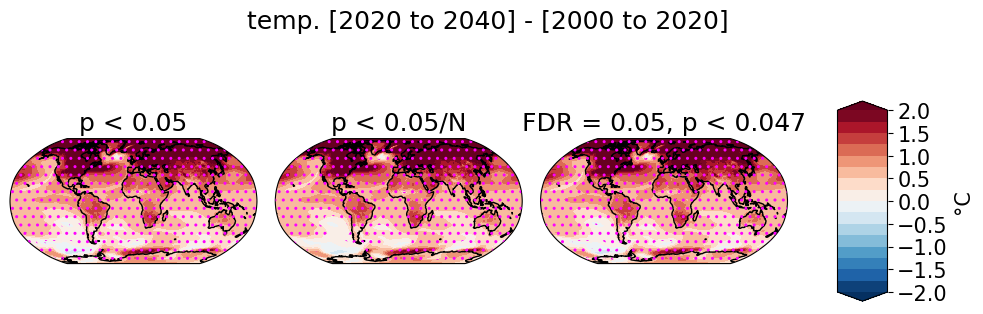

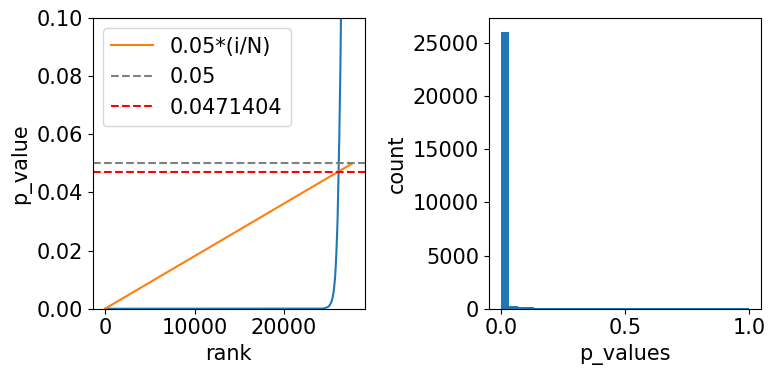

In [46]:
plot_mains(ds_1=DS.sel(year=slice(2000, 2020)).isel(Ensemble_member=0),
           ds_2=DS.sel(year=slice(2020, 2040)).isel(Ensemble_member=1), 
           suptitle='temp. [2020 to 2040] - [2000 to 2020]',
           label='temp_trend',
           var='tas',
           col_bar_label = '°C',
           p_thresh = 0.05,
           alpha = 0.05,
           clevs=np.arange(-2,2.1,0.25),
           cols = 'RdBu_r')

In [22]:
## repeat with some pr data, where the noise is large: 
DS_pr = get_historical_ssp245_ds('pr')
DS_pr = DS_pr.groupby(DS_pr.time.dt.year).mean()*86400

0.0
0.07208478009259259


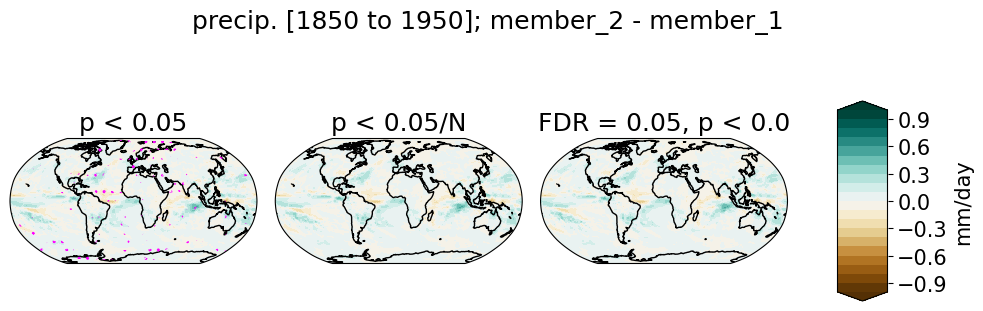

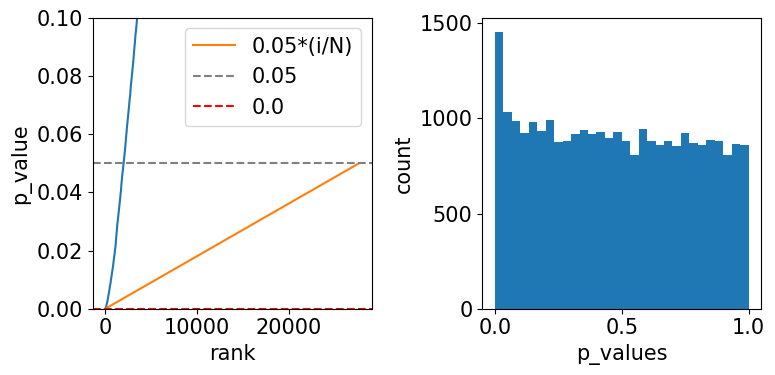

In [56]:
sgms = plot_mains(ds_1=DS_pr.sel(year=slice(1850, 1950)).isel(Ensemble_member=0),
                   ds_2=DS_pr.sel(year=slice(1850, 1950)).isel(Ensemble_member=1), 
                   suptitle='precip. [1850 to 1950]; member_2 - member_1',
                   label='pr_PI_members',
                   var='pr',
                   col_bar_label = 'mm/day',
                   p_thresh = 0.05,
                   alpha = 0.05,
                   clevs=np.arange(-1,1.1,0.1),
                   cols = 'BrBG')

print(sgms[0].sum().item()/N)

In [52]:
### now add an artifical signal to the precip case
## now add a signal to the noise

def generate_circular_region(y, x, center, radius, magnitude=1):
    """
    Generate an xarray dataset where values increase to a maximum at the center of a circular region and decay near the edges.
    
    Parameters:
    y (array-like): Array of latitude values.
    x (array-like): Array of longitude values.
    center (tuple): (y_center, x_center) coordinates of the circle center.
    radius (float): Radius of the circular region.
    
    Returns:
    xarray.Dataset: Dataset with values peaking at the center and falling off near the edge.
    """
    yy, xx = np.meshgrid(y, x, indexing='ij')
    distance = np.sqrt((yy - center[0])**2 + (xx - center[1])**2)
    
    data = magnitude*np.exp(-((distance / radius) ** 2) * 4)  # Gaussian decay near edge
    data[distance > radius] = 0  # Set values outside the circle to zero
    
    ds = xr.Dataset(
        {
            "signal": (["y", "x"], data)
        },
        coords={
            "y": y,
            "x": x
        }
    )
    
    return ds


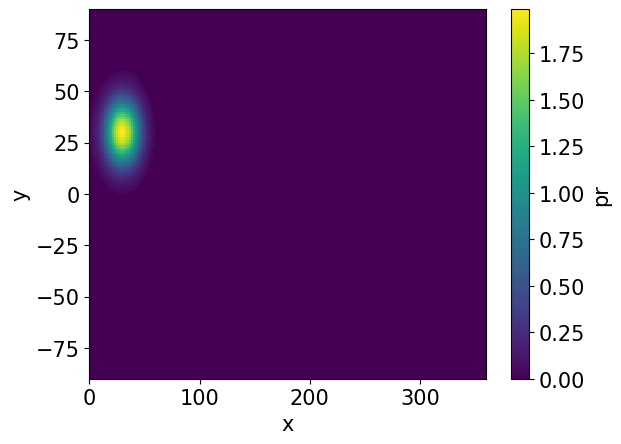

In [55]:
ds_signal = generate_circular_region(y=DS_pr.y.values, x=DS_pr.x.values, center=(30, 30), radius=30).rename({'signal':'pr'})
ds_signal.pr.plot()

0.0017881315136472837
0.11845341435185185


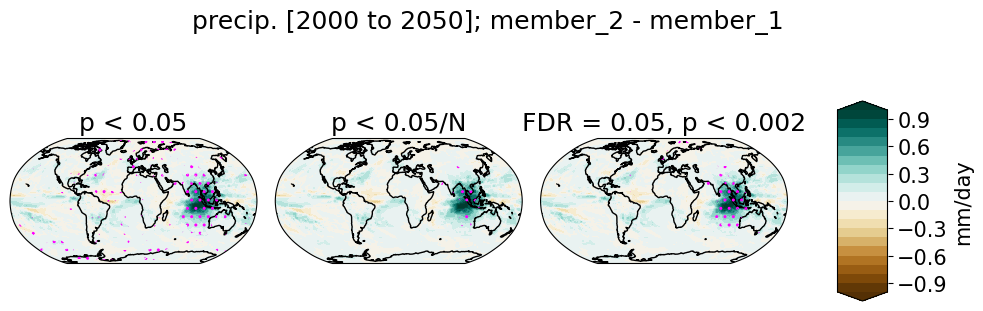

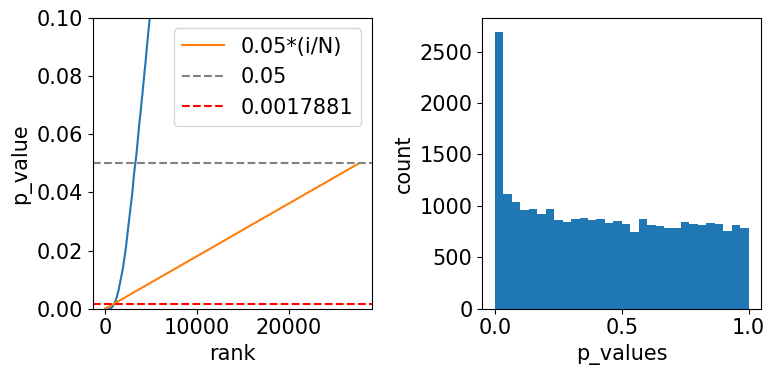

In [64]:
small_signal = generate_circular_region(y=DS_pr.y.values, x=DS_pr.x.values, center=(0, 100), radius=50, magnitude=0.75).rename({'signal':'pr'})
sgms = plot_mains(ds_1=DS_pr.sel(year=slice(1850, 1950)).isel(Ensemble_member=0),
                   ds_2=DS_pr.sel(year=slice(1850, 1950)).isel(Ensemble_member=1)+small_signal, 
                   suptitle='precip. [2000 to 2050]; member_2 - member_1, plus small signal',
                   label='pr_members_plus_small_signal',
                   var='pr',
                   col_bar_label = 'mm/day',
                   p_thresh = 0.05,
                   alpha = 0.05,
                   clevs=np.arange(-1,1.1,0.1),
                   cols = 'BrBG')

print(sgms[0].sum().item()/N)

0.004048695691808444
0.1517650462962963


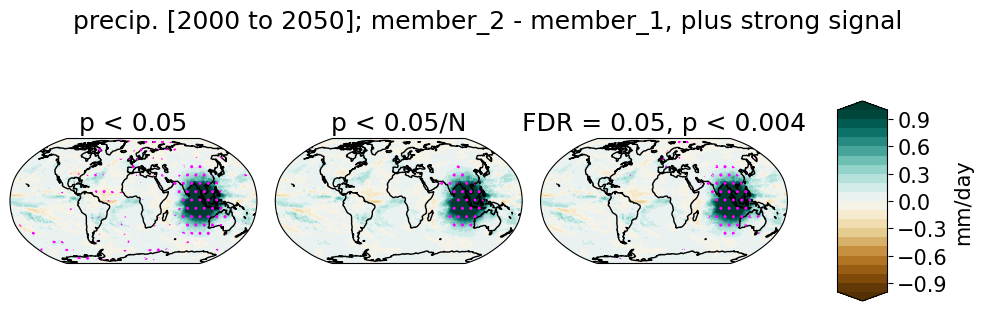

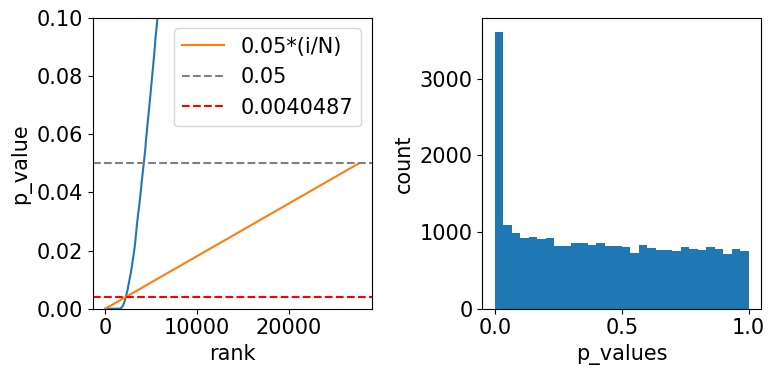

In [65]:
big_signal = generate_circular_region(y=DS_pr.y.values, x=DS_pr.x.values, center=(0, 100), radius=50, magnitude=2).rename({'signal':'pr'})
sgms = plot_mains(ds_1=DS_pr.sel(year=slice(1850, 1950)).isel(Ensemble_member=0),
                   ds_2=DS_pr.sel(year=slice(1850, 1950)).isel(Ensemble_member=1)+big_signal, 
                   suptitle='precip. [2000 to 2050]; member_2 - member_1, plus strong signal',
                   label='pr_members_plus_big_signal',
                   var='pr',
                   col_bar_label = 'mm/day',
                   p_thresh = 0.05,
                   alpha = 0.05,
                   clevs=np.arange(-1,1.1,0.1),
                   cols = 'BrBG')

print(sgms[0].sum().item()/N)

In [66]:
### now repeat for some artificial data with controlled properties

def generate_spatial_noise(lat, lon, length_scale, seed=None):
    """
    Generate an xarray dataset containing spatially correlated random noise over multiple years.
    
    Parameters:
    lat (array-like): Array of latitude values.
    lon (array-like): Array of longitude values.
    length_scale (float): Correlation length scale (in degrees, assuming lat/lon grid).
    seed (int, optional): Random seed for reproducibility.
    
    Returns:
    xarray.Dataset: Dataset containing the spatially correlated noise with a year dimension.
    """
    if seed is not None:
        np.random.seed(seed)
    
    nx, ny = len(lon), len(lat)
    years = np.arange(50)  # 50-year period
    
    noise_data = np.zeros((50, ny, nx))
    
    for i, year in enumerate(years):
        # Create wavenumbers
        kx = fftfreq(nx, d=np.abs(lon[1] - lon[0]))
        ky = fftfreq(ny, d=np.abs(lat[1] - lat[0]))
        kx, ky = np.meshgrid(kx, ky)
        k2 = kx**2 + ky**2
        
        # Define the power spectral density (Gaussian decay in frequency domain)
        psd = np.exp(-k2 * (length_scale**2))
        
        # Generate random noise in Fourier space
        noise_ft = (np.random.normal(size=(ny, nx)) + 1j * np.random.normal(size=(ny, nx))) * np.sqrt(psd)
        
        # Transform back to real space
        noise = np.real(ifft2(noise_ft))
        
        # Normalize to have zero mean and unit variance
        noise_data[i] = (noise - np.mean(noise)) / np.std(noise)
    
    # Create xarray dataset
    ds = xr.Dataset(
        {
            "noise": (["year", "y", "x"], noise_data)
        },
        coords={
            "year": years,
            "y": lat,
            "x": lon
        }
    )
    
    return ds


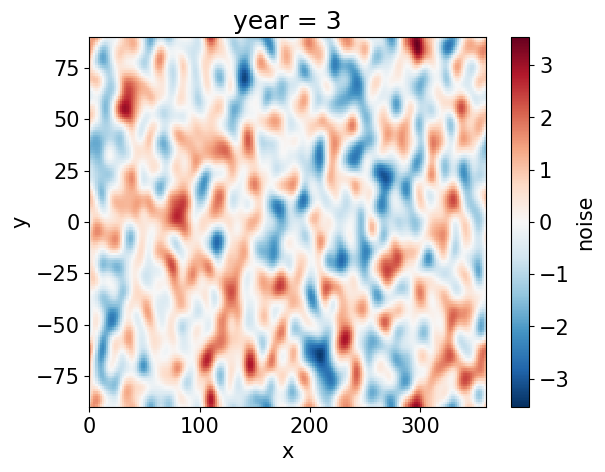

In [79]:
noise = generate_spatial_noise(lat=DS_pr.y.values, lon=DS_pr.x.values, length_scale=30, seed=None)
noise.isel(year=3).noise.plot()

0.0018067167917372622
0.17223668981481483


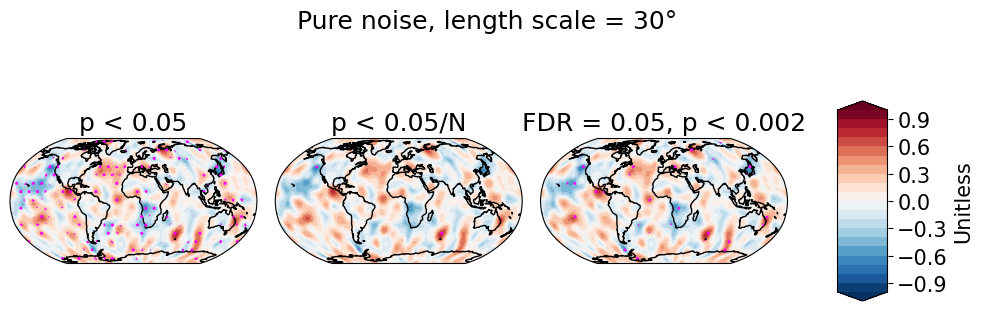

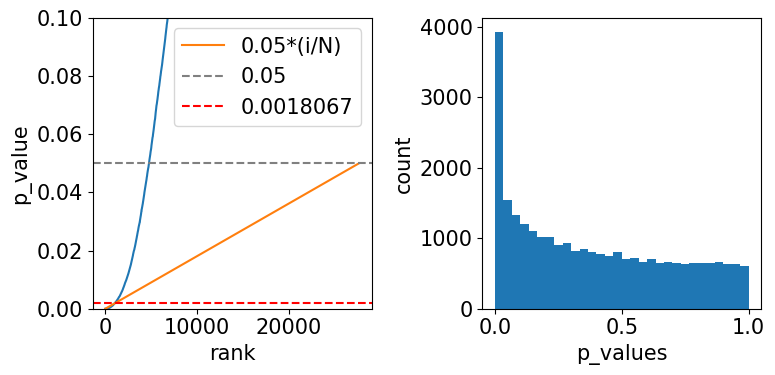

In [80]:
sgms = plot_mains(ds_1=generate_spatial_noise(lat=DS_pr.y.values, lon=DS_pr.x.values, length_scale=30, seed=None),
                   ds_2=generate_spatial_noise(lat=DS_pr.y.values, lon=DS_pr.x.values, length_scale=30, seed=None), 
                   suptitle='Pure noise, length scale = 30°',
                   label='noise',
                   var='noise',
                   col_bar_label = 'Unitless',
                   p_thresh = 0.05,
                   alpha = 0.05,
                   clevs=np.arange(-1,1.1,0.1),
                   cols = 'RdBu_r')
print(sgms[0].sum().item()/N)

In [82]:
N*0.05~

1382.4

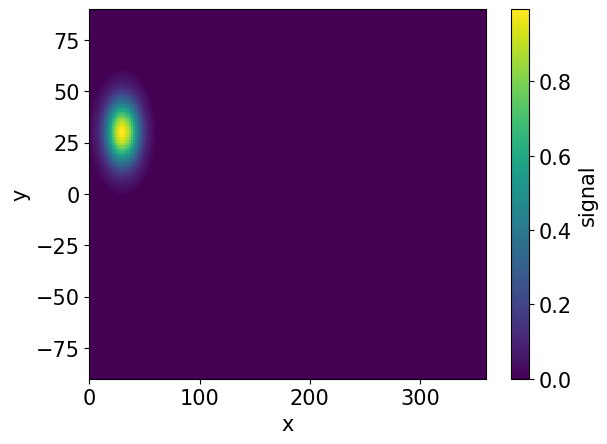

In [247]:
## now add a signal to the noise

def generate_circular_region(y, x, center, radius, magnitude=1):
    """
    Generate an xarray dataset where values increase to a maximum at the center of a circular region and decay near the edges.
    
    Parameters:
    y (array-like): Array of latitude values.
    x (array-like): Array of longitude values.
    center (tuple): (y_center, x_center) coordinates of the circle center.
    radius (float): Radius of the circular region.
    
    Returns:
    xarray.Dataset: Dataset with values peaking at the center and falling off near the edge.
    """
    yy, xx = np.meshgrid(y, x, indexing='ij')
    distance = np.sqrt((yy - center[0])**2 + (xx - center[1])**2)
    
    data = magnitude*np.exp(-((distance / radius) ** 2) * 4)  # Gaussian decay near edge
    data[distance > radius] = 0  # Set values outside the circle to zero
    
    ds = xr.Dataset(
        {
            "signal": (["y", "x"], data)
        },
        coords={
            "y": y,
            "x": x
        }
    )
    
    return ds

ds_signal = generate_circular_region(y=DS_pr.y.values, x=DS_pr.x.values, center=(30, 30), radius=30)
ds_signal.signal.plot()

In [248]:
## now repeat with a signal 

0.00744265541540673


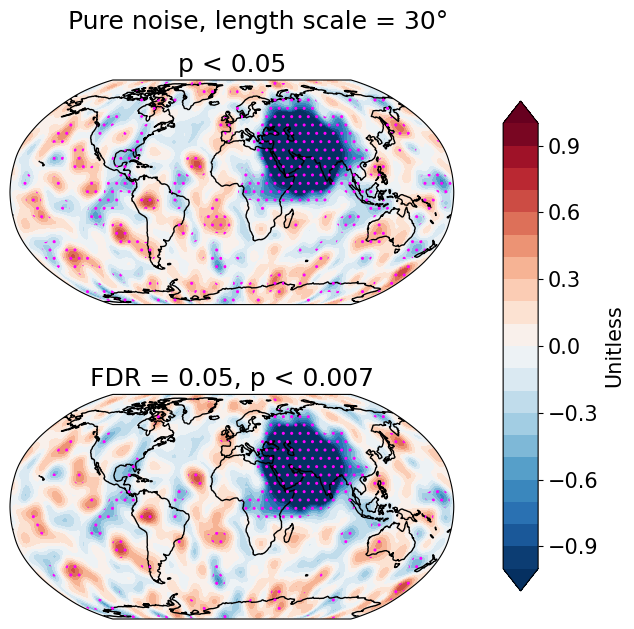

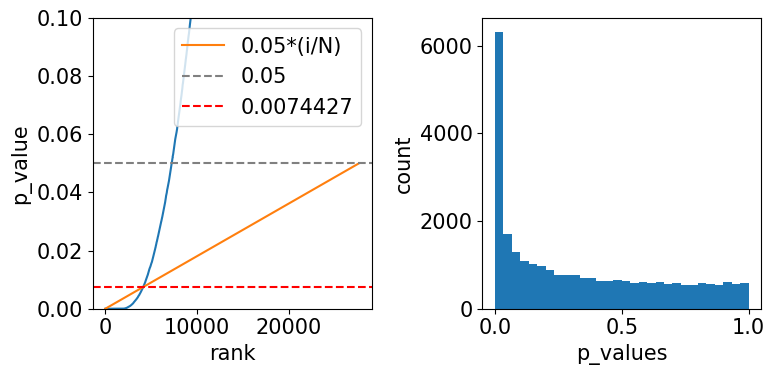

In [249]:
signal = generate_circular_region(y=DS_pr.y.values, x=DS_pr.x.values, center=(30, 60), radius=50, magnitude=5).rename({'signal':'noise'})
sgms = plot_mains(ds_1=generate_spatial_noise(lat=DS_pr.y.values, lon=DS_pr.x.values, length_scale=30, seed=None)+signal,
           ds_2=generate_spatial_noise(lat=DS_pr.y.values, lon=DS_pr.x.values, length_scale=30, seed=None), 
           suptitle='Pure noise, length scale = 30°',
           label='noise',
           var='noise',
           col_bar_label = 'Unitless',
           p_thresh = 0.05,
           alpha = 0.05,
           clevs=np.arange(-1,1.1,0.1),
           cols = 'RdBu_r')


In [250]:
def FDR(ds_sigmask, signal):
    """ returns fraction of local null hypothesis test rejections 
        (“discoveries”) for which the null hypothesis is actually true """
    return (ds_sigmask.where(signal==0).noise.sum().item()/ds_sigmask.sum().item())
    
def TDR(ds_sigmask, signal):
    """ returns fraction of true null hyopthesis rejections discovered """
    return (ds_sigmask.where(signal>0).noise.sum().item()/xr.where(signal.noise > 0, 1, 0).sum().item())

In [251]:
print(FDR(sgms[0], signal))
print(TDR(sgms[0], signal))

print(FDR(sgms[1], signal))
print(TDR(sgms[1], signal))

0.6428373893805309
0.7705847255369929
0.4225078826097502
0.7103221957040573
